## Data
###### instructions followed from https://beckernick.github.io/matrix-factorization-recommender/

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse.linalg import svds

In [2]:
#import the tables
movieDF = pd.read_csv("files/movie.csv")
ratingDF = pd.read_csv("files/rating.csv")

In [3]:
movieDF.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


## Data Filtering

In [5]:
len(ratingDF)
tempRatingDF = ratingDF.groupby("movieId", as_index=False)
print(tempRatingDF.count())
#noticed that there are movies who received 1 total rating

       movieId  userId  rating  timestamp
0            1   49695   49695      49695
1            2   22243   22243      22243
2            3   12735   12735      12735
3            4    2756    2756       2756
4            5   12161   12161      12161
...        ...     ...     ...        ...
26739   131254       1       1          1
26740   131256       1       1          1
26741   131258       1       1          1
26742   131260       1       1          1
26743   131262       1       1          1

[26744 rows x 4 columns]


<AxesSubplot:xlabel='movieId', ylabel='rating'>

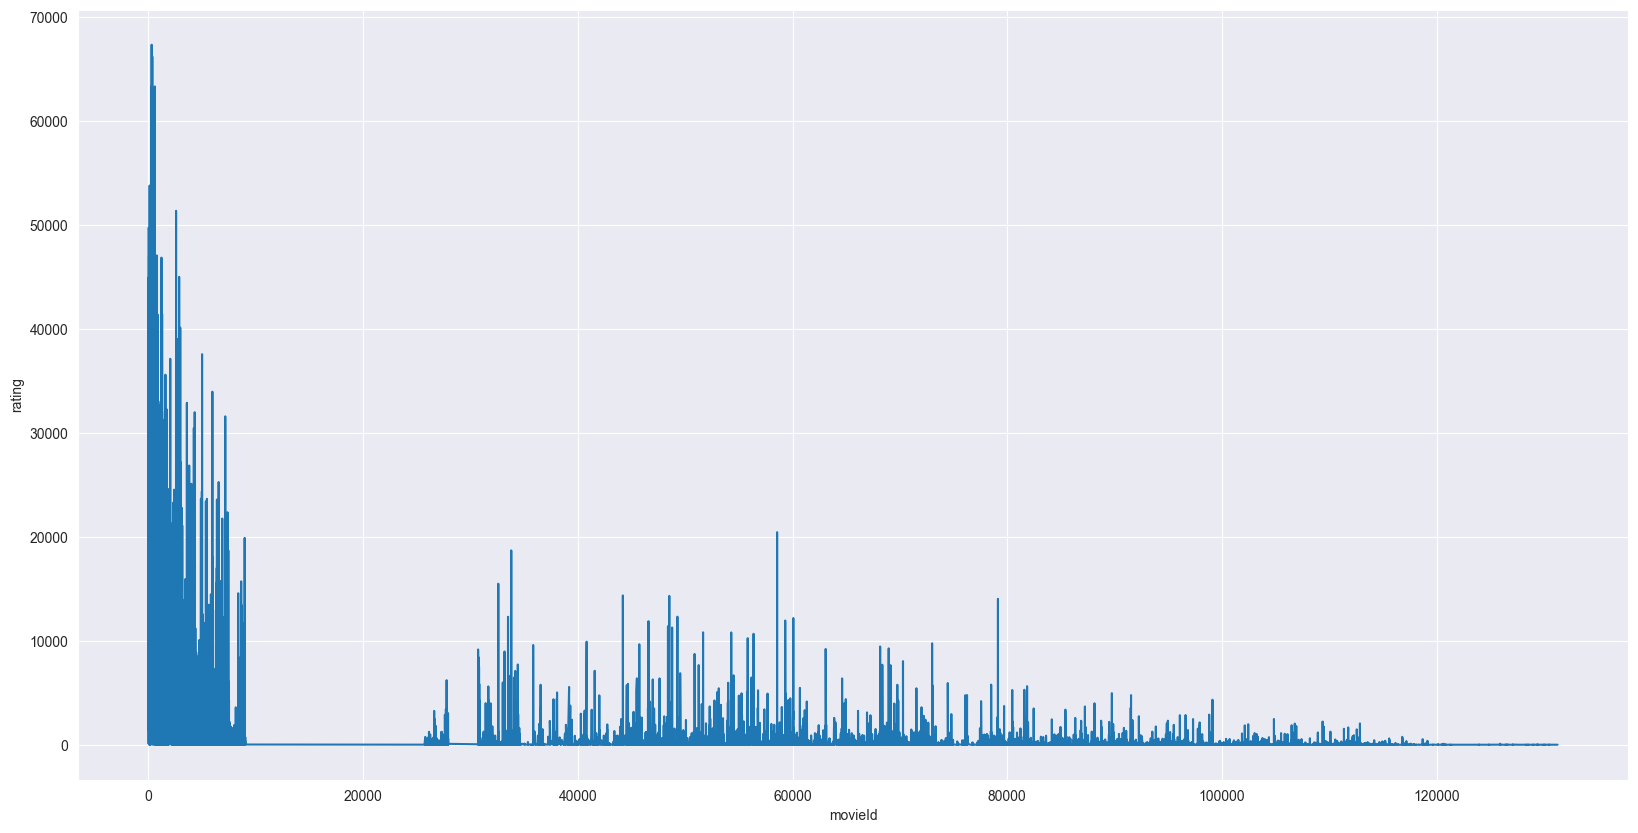

In [6]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
sns.lineplot(data = tempRatingDF.count(), y="rating", x="movieId")

In [7]:
#filter movies that are rated with less than 100 users
tempRatingDF = tempRatingDF.count()
tempRatingDFA = tempRatingDF[tempRatingDF['rating'] > 100]

In [8]:
#create list of the tempratingDFA to be used in a new table needed for the filtered movies with less than 100 ratings from users
ratingMovieList = tempRatingDFA['movieId'].tolist()
filteredRatingDF = ratingDF[ratingDF.movieId.isin(ratingMovieList)]
# len(filteredRatingDF)

## Modeling

In [9]:
#unlike the knn implementation earlier, we are creating features out of movies
movieFeaturesDF = filteredRatingDF.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

In [10]:
movieFeaturesDF.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,116797,116823,116977,117176,117590,118696,118900,118997,119141,119145
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#Demean and normalize by each user.
#convert the dataframe into a numpy array
rating = movieFeaturesDF.values
userRatingsMean = np.mean(rating, axis = 1)
ratingDemeaned = rating - userRatingsMean.reshape(-1, 1)

### Using Singular Value Decomposition

In [12]:
#using svd out of scipy library as it is more latent in choosing factors we would want to approximate 
U, sigma, Vt = svds(ratingDemeaned, k = 50)

In [13]:
#Create a diagonal matrix form
sigma = np.diag(sigma)

### Making Predictions from the Decomposed Matrices

In [14]:
allUserPredictedRatings = np.dot(np.dot(U, sigma), Vt) + userRatingsMean.reshape(-1, 1)
predictionsDF = pd.DataFrame(allUserPredictedRatings, columns = movieFeaturesDF.columns)

In [15]:
predictionsDF.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,116797,116823,116977,117176,117590,118696,118900,118997,119141,119145
0,-0.512866,1.048497,0.031295,-0.085424,-0.103918,0.435473,-0.306753,0.009229,-0.161947,-0.376915,...,-0.005681,0.042833,0.004522,-0.022779,-0.007323,0.038899,0.003944,0.012157,0.002231,0.004296
1,0.987601,-0.080765,0.237280,0.076614,0.222247,0.114726,0.343168,0.029418,0.087289,-0.254168,...,-0.017689,0.002431,0.004438,-0.001683,0.005367,0.001305,-0.001831,0.001018,0.004406,-0.000198
2,1.813015,0.839917,-0.104427,-0.065587,-0.154145,0.276624,-0.243712,0.007118,-0.013556,-0.026129,...,0.047271,0.010933,0.012834,0.026380,0.008130,-0.045788,0.017362,0.008170,0.012336,-0.007892
3,-0.716183,0.634366,0.277562,0.019803,0.166646,0.912720,0.028585,0.069964,0.195359,1.049164,...,-0.008020,-0.013082,-0.001935,-0.004230,-0.000316,-0.004675,-0.001338,-0.001812,-0.003002,-0.003406
4,1.969419,1.467411,1.215415,0.195598,1.212176,0.463718,1.463329,0.196678,0.211016,1.397162,...,-0.007997,-0.014994,-0.007840,-0.006987,-0.007416,0.000248,-0.001478,-0.006376,-0.000864,-0.001596


### Making Movie Recommendations

In [16]:
%run mf_util

<Figure size 640x480 with 0 Axes>

## Try the recommender

In [17]:
currentUserId = 1

In [18]:
%run mf_util
ratedByUser, movieReccomendations = recommendMovies(predictionsDF, currentUserId, movieDF, ratingDF, 10)

User 1 has already rated 175 movies.


In [19]:
ratedByUser

,userId,movieId,rating,timestamp,title,genres
170,1,8507,5.0,2004-09-10 03:13:47,Freaks (1932),Crime|Drama|Horror
131,1,4993,5.0,2005-04-02 23:31:22,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
142,1,5952,5.0,2005-04-02 23:30:19,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
158,1,7153,5.0,2005-04-02 23:30:33,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
30,1,1196,4.5,2005-04-02 23:32:22,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
...,...,...,...,...,...,...
89,1,2761,3.0,2005-04-02 23:32:39,"Iron Giant, The (1999)",Adventure|Animation|Children|Drama|Sci-Fi
41,1,1243,3.0,2005-04-02 23:46:07,Rosencrantz and Guildenstern Are Dead (1990),Comedy|Drama
128,1,4915,3.0,2005-04-02 23:54:36,"Beastmaster, The (1982)",Action|Adventure|Fantasy
33,1,1201,3.0,2005-04-02 23:30:42,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western


In [20]:
movieReccomendations

,movieId,title,genres
1141,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
2404,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1029,1073,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical
1961,2115,Indiana Jones and the Temple of Doom (1984),Action|Adventure|Fantasy
584,608,Fargo (1996),Comedy|Crime|Drama|Thriller
1146,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller
5381,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy
1198,1275,Highlander (1986),Action|Adventure|Fantasy
3593,3793,X-Men (2000),Action|Adventure|Sci-Fi
746,778,Trainspotting (1996),Comedy|Crime|Drama


##### Conclusion: According to the results filtered by our function showing the rated movies and the movie recomendations, we could somehow deduce that the predications are relatively good in contrast to the movies potentially watched by the user.